# *Topic Model Comparison for USGS Model Catalog Abstracts:*

In [1]:
%%capture
# !pip install contextualized-topic-models==1.8.1
!pip install sentence-transformers
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

## Import libaries and dependencies

In [2]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/contextualized-topic-models-master

/content/drive/MyDrive/contextualized-topic-models-master


In [6]:
from contextualized_topic_models.models.ctm import CombinedTM, ZeroShotTM
from contextualized_topic_models.utils.data_preparation import bert_embeddings_from_file, TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
from contextualized_topic_models.datasets.dataset import CTMDataset
from contextualized_topic_models.evaluation.measures import CoherenceNPMI, InvertedRBO
import gensim
from gensim.corpora.dictionary import Dictionary
import os
import numpy as np
import pickle
import pandas as pd
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Preparation

### Read our data files and store the documents as lists of strings

In [7]:
# MODEL DATA CATALOG ABSTRACT DATA:
df = pd.read_csv('abstracts.csv')
df["title_text"] = df["Title"] + ' ' + df["Text"]
wp = WhiteSpacePreprocessing(df.title_text)
text_training_preprocessed, text_training_not_preprocessed, vocab_list = wp.preprocess()

#### NOTE: Make sure that the lenghts of the two lists of documents are the same and the index of a not preprocessed document corresponds to the index of the same preprocessed document.

In [8]:
print(len(text_training_preprocessed) == len(text_training_not_preprocessed))

True


## Split into Train/Test Sets

In [9]:
# contextual documents are used in neural topic models whereas other models, such as LDA, only take BoW

training_bow_documents = text_training_preprocessed[0:38]
training_contextual_document = text_training_not_preprocessed[0:38]

testing_bow_documents = text_training_preprocessed[38:]
testing_contextual_documents = text_training_not_preprocessed[38:]

# Neural Topic Modeling

In [10]:
# colab example https://colab.research.google.com/drive/12zBvL0v0qZHbpSGXLLjHfQ0w6OZOVHaB#scrollTo=KhLt6VA3wvCB
# github https://github.com/MilaNLProc/contextualized-topic-models#preprocessing
# prodLDA https://arxiv.org/pdf/1703.01488.pdf
# neural prodLDA + specter embedding rep article https://arxiv.org/pdf/2004.03974v1.pdf

## **CTM Overview**
#### Combine pre-trained representations (from SPECTER)and neural topic model (neural prodLDA) = Contextualized Topic Model (CTM). Most topic models still use Bag of Words (BoW) document representations as model input, rather than contextualized representations - see [LDA](https://colab.research.google.com/drive/1VkOBoXC298_-QG6PllBJ-IimHsajLlgR#scrollTo=-P9GmgEZPyIv) below. BoW representations do not account for syntactic and semantic relationships among the words in a document.
#### 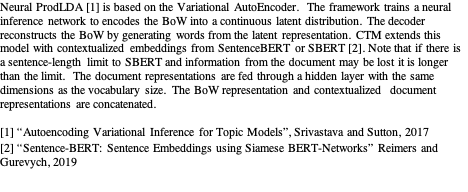

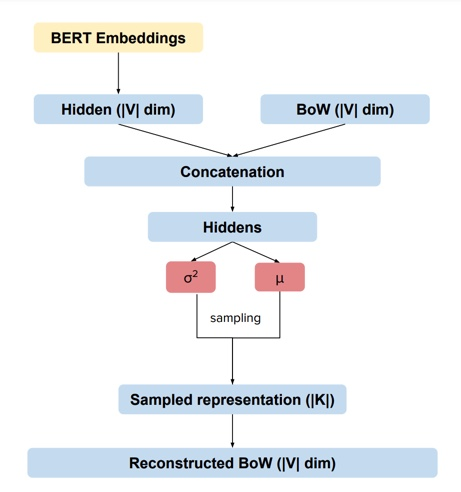

In [11]:
#uncomment to use regular BERT
# tp = TopicModelDataPreparation("bert-base-nli-mean-tokens")

# Using SPECTER from ALLENAI
tp = TopicModelDataPreparation("allenai-specter")

In [12]:
training_dataset = tp.create_training_set(training_contextual_document, training_bow_documents)

##### Let's check the vocabulary

In [13]:
tp.vocab[:10]

['ability',
 'absence',
 'acceleration',
 'accepted',
 'acceptor',
 'acceptors',
 'access',
 'accommodates',
 'account',
 'accounted']

## Load & Use CTM

In [14]:
ctm = CombinedTM(input_size=len(tp.vocab), bert_input_size=768, num_epochs=200, num_topics=9, model_type='prodLDA',
                 hidden_sizes=(128, 128), activation='softplus', dropout=0.2,
                 learn_priors=True, batch_size=10, lr=2e-2, momentum=0.99,
                 solver='adam', reduce_on_plateau=True, num_data_loader_workers=4)
ctm.fit(training_dataset) 

Epoch: [200/200]	 Seen Samples: [7600/7600]	Train Loss: 893.1804584703947	Time: 0:00:00.347702: : 200it [01:01,  3.24it/s]


In [15]:
# ctm = ZeroShotTM(input_size=len(tp.vocab), bert_input_size=768, num_epochs=250, num_topics=9, model_type='prodLDA',
#                  hidden_sizes=(100, 100), activation='softplus', dropout=0.2,
#                  learn_priors=True, batch_size=10, lr=2e-2, momentum=0.99,
#                  solver='adam', reduce_on_plateau=True, num_data_loader_workers=4)
# ctm.fit(training_dataset)

### Get topics list

In [16]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [17]:
ctm.get_topics(5)

defaultdict(list,
            {0: ['coastal', 'transport', 'simulation', 'report', 'sediment'],
             1: ['programs', 'slope', 'subduction', 'compiled', 'stability'],
             2: ['zones', 'regional', 'equilibrium', 'subduction', 'identify'],
             3: ['hypothesis', 'scms', 'could', 'land', 'daily'],
             4: ['species', 'fish', 'stream', 'water', 'percent'],
             5: ['vertical', 'vflux', 'profile', 'fluid', 'functions'],
             6: ['transport', 'solute', 'reactions', 'processes', 'model'],
             7: ['users', 'count', 'falling', 'programand', 'point'],
             8: ['channels', 'structure', 'balance', 'manual', 'cases']})

### Look at a word cloud

In [18]:
%%capture
pip install matplotlib==3.1.3

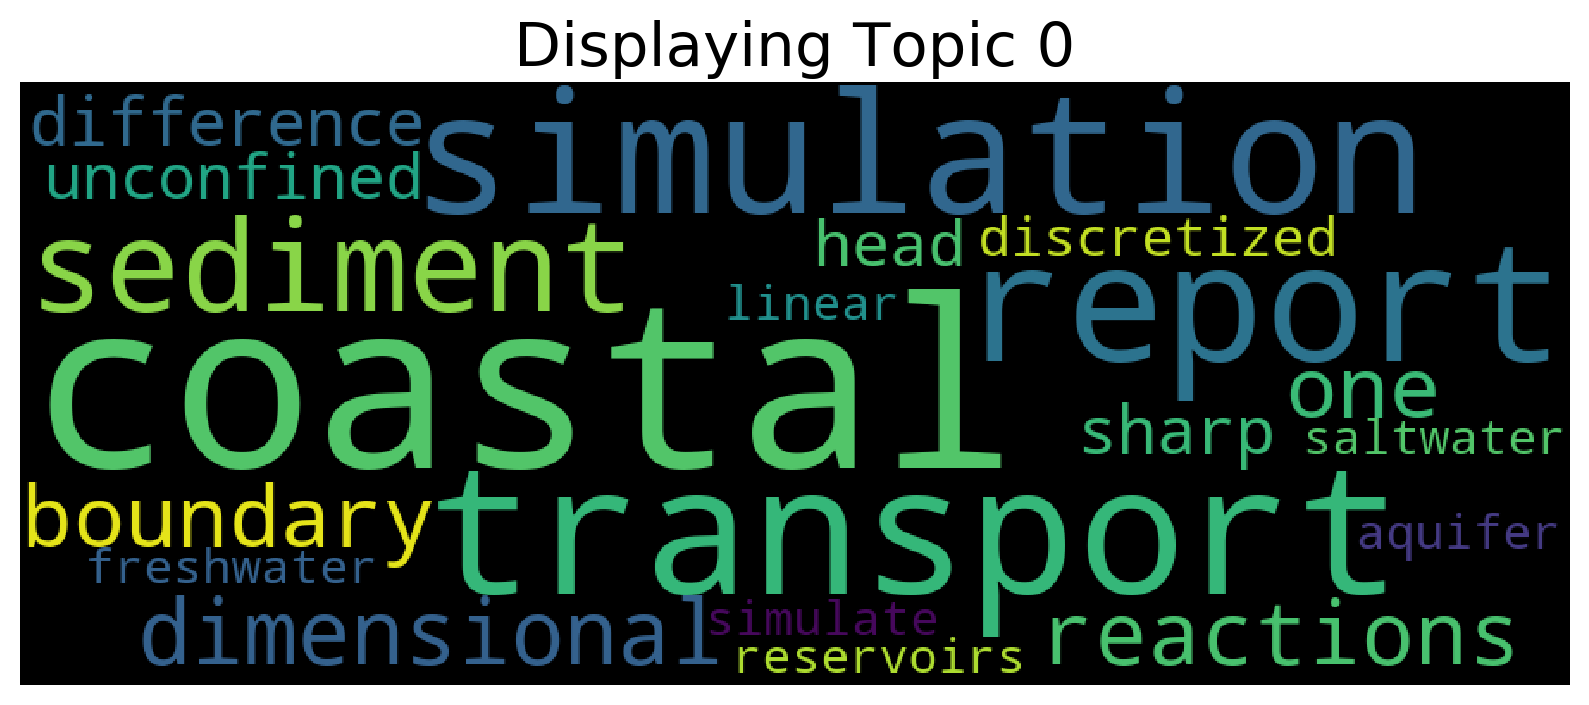

In [19]:
# Word Cloud for first topic:
ctm.get_wordcloud(topic_id=0, n_words=20)

### Validation

In [20]:
testing_dataset = tp.create_test_set(testing_contextual_documents, testing_bow_documents) # create dataset for the testset
# print(testing_dataset[0])

In [21]:
predictions = ctm.get_doc_topic_distribution(testing_dataset)

Sampling: [20/20]: : 20it [00:06,  3.31it/s]

2
9


In [22]:
pt = ctm.get_predicted_topics(testing_dataset, n_samples=2)
print(pt)

Sampling: [2/2]: : 2it [00:00,  3.39it/s]

2
9
[1, 0]


## Evaluate CTM - Coherence Score

In [23]:
#Combine topic score
texts = list(map(lambda x : x.split(), training_bow_documents))
npmi = CoherenceNPMI(texts=texts, topics=ctm.get_topic_lists(10))
npmi.score()

['coastal', 'transport', 'simulation', 'report', 'sediment', 'dimensional', 'reactions', 'boundary', 'one', 'difference']
['programs', 'slope', 'subduction', 'compiled', 'stability', 'landslide', 'versions', 'bishopgs', 'analysis', 'host']
['zones', 'regional', 'equilibrium', 'subduction', 'identify', 'wave', 'ocean', 'coupling', 'dissolution', 'chemistry']
['hypothesis', 'scms', 'could', 'land', 'daily', 'runoff', 'vegetation', 'spatial', 'size', 'generally']
['species', 'fish', 'stream', 'water', 'percent', 'models', 'climate', 'streamflow', 'vegetation', 'permanence']
['vertical', 'vflux', 'profile', 'fluid', 'functions', 'matlab', 'transfer', 'porous', 'vflu', 'environment']
['transport', 'solute', 'reactions', 'processes', 'model', 'one', 'package', 'simulation', 'report', 'sorption']
['users', 'count', 'falling', 'programand', 'point', 'running', 'programs', 'fortran', 'occur', 'maps']
['channels', 'structure', 'balance', 'manual', 'cases', 'assessment', 'thermodynamic', 'base', 

-0.20788889702701555

### **Doc2Topic Overview**

# Other Topic Models

## **LDA Overview**

#### 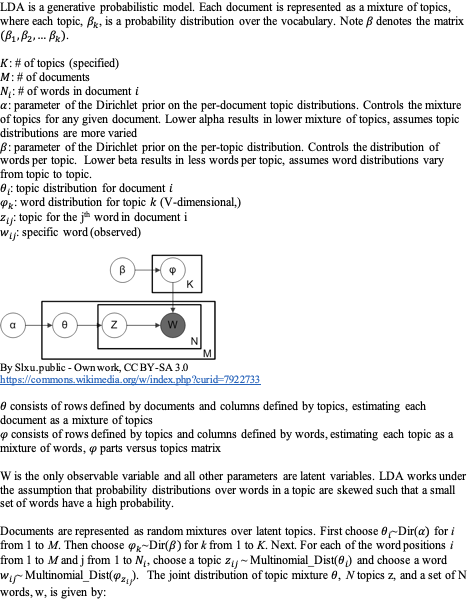
#### 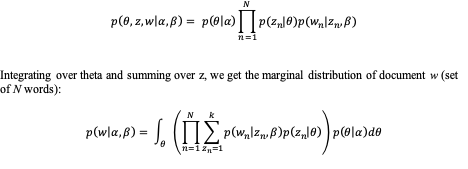

#### We are going to use gensim's LDA implementation and the preprocessed BoW text to learn topics from the abstracts for comparison

## Load & Use LDA Model

In [24]:
from gensim.models import ldamodel 

lda_text = list(map(lambda x : x.split(), training_bow_documents))

id2word = Dictionary(lda_text)
texts = lda_text
corpus = [id2word.doc2bow(text) for text in texts]

lda_model = ldamodel.LdaModel(
   corpus=corpus, id2word=id2word, num_topics=9, passes=10, alpha='auto', per_word_topics=True, iterations=200)

### Get topics list

In [25]:
lda_topics = []
for i in range(9):
    t = [w[0] for w in lda_model.show_topic(i)[0:10]]
    lda_topics.append(t)

In [26]:
lda_topics[0:2]

[['model',
  'transport',
  'results',
  'coastal',
  'precipitation',
  'thresholds',
  'degradation',
  'dimensional',
  'ocean',
  'coupling'],
 ['model',
  'water',
  'transport',
  'data',
  'flow',
  'program',
  'used',
  'tool',
  'using',
  'interface']]

### Validation

In [27]:
#add testing with LDA

## Evaluate LDA - Coherence Score

In [28]:
#LDA topics
npmi = CoherenceNPMI(texts=texts, topics=lda_topics)
npmi.score()

-0.06612410627436388

## Visualize Topcs from LDA with pyLDAvis

In [29]:
%%capture
!pip install pyLDAvis==3.3.1

In [30]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [31]:
# https://github.com/bmabey/pyLDAvis/blob/master/notebooks/Gensim%20Newsgroup.ipynb 
vis_data = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis_data)

## **HDP Overview**

## Load & Use HDP Model

In [32]:
from gensim.models import hdpmodel 

hdp = hdpmodel.HdpModel(corpus, id2word)

/usr/local/lib/python3.7/dist-packages/gensim/models/hdpmodel.py:459: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  start_time = time.clock()


In [33]:
hdptopics = hdp.show_topics(formatted=False)
hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]

In [35]:
#HDP topics
npmi = CoherenceNPMI(texts=texts, topics=hdptopics)
npmi.score()

-0.1670103138954651

## Visualize Topcs from LDA with pyLDAvis

In [36]:
vis_data = gensimvis.prepare(hdp, corpus, id2word)
pyLDAvis.display(vis_data)


In [ ]:
# Haven't figure out how to use PyLDAvis with Neural Topic Models

# vis_data = gensimvis.prepare(ctm, corpus, id2word, doc_topic_dist=topic_dist)
# pyLDAvis.display(vis_data)

# TODO AttributeError: 'CombinedTM' object has no attribute 'inference'

# see inference for hdp online 212
# https://github.com/largelymfs/topical_word_embeddings/blob/master/TWE-2/gensim/models/hdpmodel.py 

# gamma (parameters controlling the topic weights) for each document
# gamma is of shape len(chunk) x self.num_topics

# see inference for ldp on line 631
# https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/models/ldamodel.py

# spent a while on this problem, trying to figure out the equivalent to inference from lda or hdp for neural prod-lda
# also has CTM class and CombinedTM(CTM)



In [ ]:
# data = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency, R=30, lambda_step=0.01, sort_topics=True)
# # topic_term_dists: Matrix of topic-term probabilities
# # doc_topic_dists: Matrix of document-topic probabilities.
# # doc_lengths: The length of each document, i.e. the number of words in each document. The order of the numbers should be consistent with the ordering of the docs in doc_topic_dists.
# # vocab: List of all the words in the corpus used to train the model.
# # term_frequency: The count of each particular term over the entire corpus. The ordering of these counts should correspond with vocab and topic_term_dists.
# # R=30: The number of terms to display in the barcharts of the visualization. Default is 30. Recommended to be roughly between 10 and 50.
# pyLDAvis.display(data)

# Other Models to Compare:
LFTM 

GSDMM 
Non-Negative Matrix factorization (NMF)
Hierarchical Dirichlet Processing Model (HDP)
Latent Semantic Indexing (LSI)
Paragraph Vector Topic Model (PVTM) 